# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

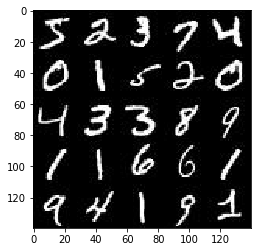

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

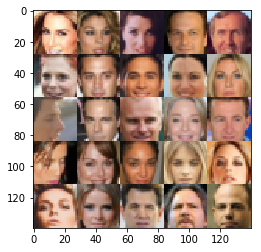

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_image_input = tf.placeholder(tf.float32,
                                      (None, image_width, image_height , image_channels),
                                      name='real_input')
    z_data_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_image_input, z_data_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # 28x28 (dim)
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(conv1, alpha*conv1)
        # 14x14 (dim)
        conv2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(bn2, alpha*bn2)
        # logits
        logits = tf.layers.dense(tf.reshape(relu2, (-1, 7*7*128)), 1)
        out = tf.sigmoid(logits)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope('generator', reuse= not is_train):
        # fully connected first layer
        fc = tf.reshape(tf.layers.dense(z, 7*7*256), (-1, 7, 7, 256))
        bn1 =  tf.layers.batch_normalization(fc, training=is_train)
        relu1 = tf.maximum(alpha*bn1, bn1)
        # 7x7x256
    
        # first transpose conv
        conv1 = tf.layers.conv2d_transpose(relu1, 128, 5, strides=2, padding='same')
        bn2 =  tf.layers.batch_normalization(conv1, training=is_train)
        relu2 = tf.maximum(alpha*bn2, bn2)
        # 14x14x128
        
        # second transpose conv
        logits = tf.layers.conv2d_transpose(relu2, out_channel_dim, 5, strides=2, padding='same')
    
        return tf.tanh(logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_real,
        labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                    labels = tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                    labels=tf.ones_like(d_model_fake)))
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss,
                                                                                  var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss,
                                                                                  var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [42]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    # Building Model
    print("batch size: {}".format(batch_size))
    real_image_input, z_data_input, learning_rate_t = model_inputs(data_shape[1], data_shape[2]
                                                                 , data_shape[3],  z_dim)
    d_loss, g_loss = model_loss(input_real=real_image_input, input_z=z_data_input,
                                out_channel_dim=data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate_t, beta1)
    
    steps = 0
    print_every = 5
    show_every = 20
    to_show_images = 25

    # losses = []

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            batch_ = 0
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_ += 1
                batch_z = np.random.uniform(-1, 1, size=[batch_size, z_dim])
                _ = sess.run(d_opt, feed_dict={real_image_input:batch_images,
                                               z_data_input: batch_z,
                                               learning_rate_t: learning_rate})
                _ = sess.run(g_opt, feed_dict={real_image_input:batch_images,
                                               z_data_input: batch_z,
                                              learning_rate_t: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({real_image_input:batch_images,
                                                   z_data_input: batch_z})
                    train_loss_g = g_loss.eval({z_data_input: batch_z})

                    print("Epoch {}/{}... batch: {}".format(epoch_i+1, epoch_count, batch_),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    # losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, to_show_images, z_data_input, data_shape[3], data_image_mode)

        # final model state (visualization)
        show_generator_output(sess, to_show_images, z_data_input, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1) L
batch size: 128
Epoch 1/2... batch: 5 Discriminator Loss: 1.2132... Generator Loss: 0.4402
Epoch 1/2... batch: 10 Discriminator Loss: 1.3741... Generator Loss: 0.4113
Epoch 1/2... batch: 15 Discriminator Loss: 1.2692... Generator Loss: 0.5485
Epoch 1/2... batch: 20 Discriminator Loss: 1.1409... Generator Loss: 0.7102


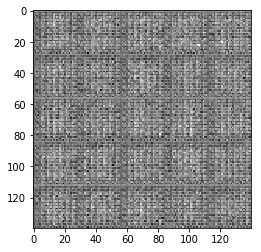

Epoch 1/2... batch: 25 Discriminator Loss: 1.4479... Generator Loss: 0.5850
Epoch 1/2... batch: 30 Discriminator Loss: 1.8338... Generator Loss: 0.5759
Epoch 1/2... batch: 35 Discriminator Loss: 1.7777... Generator Loss: 0.5342
Epoch 1/2... batch: 40 Discriminator Loss: 1.4994... Generator Loss: 0.6907


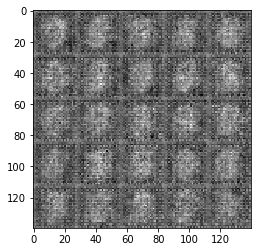

Epoch 1/2... batch: 45 Discriminator Loss: 1.3765... Generator Loss: 0.7340
Epoch 1/2... batch: 50 Discriminator Loss: 1.0753... Generator Loss: 1.0120
Epoch 1/2... batch: 55 Discriminator Loss: 1.1854... Generator Loss: 0.9249
Epoch 1/2... batch: 60 Discriminator Loss: 1.4130... Generator Loss: 0.6530


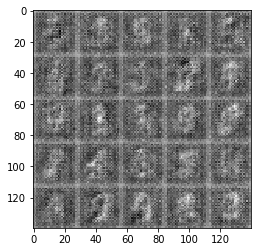

Epoch 1/2... batch: 65 Discriminator Loss: 1.0895... Generator Loss: 0.8322
Epoch 1/2... batch: 70 Discriminator Loss: 1.2924... Generator Loss: 0.7081
Epoch 1/2... batch: 75 Discriminator Loss: 1.2706... Generator Loss: 0.8246
Epoch 1/2... batch: 80 Discriminator Loss: 1.2410... Generator Loss: 0.7619


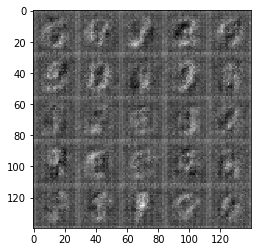

Epoch 1/2... batch: 85 Discriminator Loss: 0.9646... Generator Loss: 1.0940
Epoch 1/2... batch: 90 Discriminator Loss: 1.1607... Generator Loss: 0.6563
Epoch 1/2... batch: 95 Discriminator Loss: 0.9682... Generator Loss: 1.1627
Epoch 1/2... batch: 100 Discriminator Loss: 1.1748... Generator Loss: 0.6325


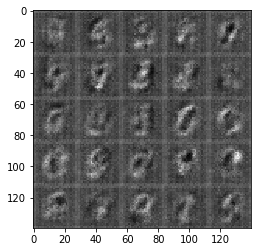

Epoch 1/2... batch: 105 Discriminator Loss: 0.9862... Generator Loss: 1.4841
Epoch 1/2... batch: 110 Discriminator Loss: 1.0221... Generator Loss: 0.9535
Epoch 1/2... batch: 115 Discriminator Loss: 0.8932... Generator Loss: 1.7245
Epoch 1/2... batch: 120 Discriminator Loss: 0.8885... Generator Loss: 1.0499


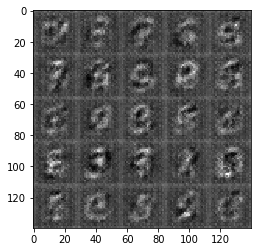

Epoch 1/2... batch: 125 Discriminator Loss: 0.9379... Generator Loss: 0.7665
Epoch 1/2... batch: 130 Discriminator Loss: 0.9772... Generator Loss: 0.6901
Epoch 1/2... batch: 135 Discriminator Loss: 0.9603... Generator Loss: 0.7169
Epoch 1/2... batch: 140 Discriminator Loss: 0.7605... Generator Loss: 0.8585


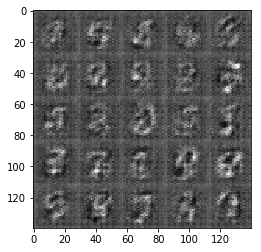

Epoch 1/2... batch: 145 Discriminator Loss: 0.9492... Generator Loss: 1.8750
Epoch 1/2... batch: 150 Discriminator Loss: 0.8580... Generator Loss: 1.3151
Epoch 1/2... batch: 155 Discriminator Loss: 0.7260... Generator Loss: 0.9796
Epoch 1/2... batch: 160 Discriminator Loss: 0.9982... Generator Loss: 1.3595


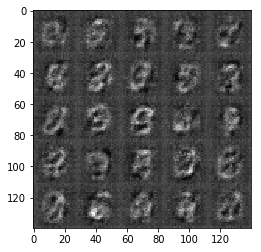

Epoch 1/2... batch: 165 Discriminator Loss: 0.7124... Generator Loss: 1.4281
Epoch 1/2... batch: 170 Discriminator Loss: 0.9386... Generator Loss: 0.6570
Epoch 1/2... batch: 175 Discriminator Loss: 0.8128... Generator Loss: 0.8569
Epoch 1/2... batch: 180 Discriminator Loss: 0.9590... Generator Loss: 0.8249


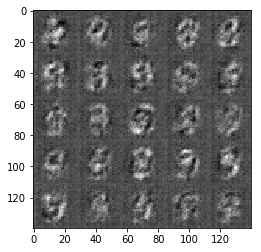

Epoch 1/2... batch: 185 Discriminator Loss: 0.7837... Generator Loss: 1.0479
Epoch 1/2... batch: 190 Discriminator Loss: 0.7753... Generator Loss: 0.9135
Epoch 1/2... batch: 195 Discriminator Loss: 0.7811... Generator Loss: 1.2540
Epoch 1/2... batch: 200 Discriminator Loss: 0.7766... Generator Loss: 0.8444


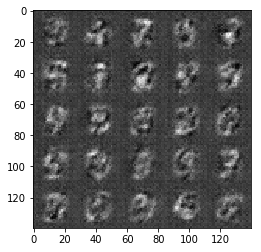

Epoch 1/2... batch: 205 Discriminator Loss: 0.6549... Generator Loss: 1.1504
Epoch 1/2... batch: 210 Discriminator Loss: 0.8586... Generator Loss: 0.7385
Epoch 1/2... batch: 215 Discriminator Loss: 1.0403... Generator Loss: 0.5573
Epoch 1/2... batch: 220 Discriminator Loss: 0.8025... Generator Loss: 0.9395


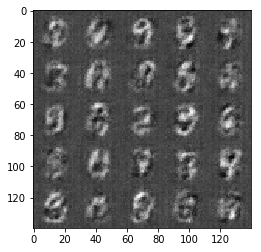

Epoch 1/2... batch: 225 Discriminator Loss: 0.8246... Generator Loss: 0.8629
Epoch 1/2... batch: 230 Discriminator Loss: 0.7364... Generator Loss: 0.9992
Epoch 1/2... batch: 235 Discriminator Loss: 0.8132... Generator Loss: 1.2801
Epoch 1/2... batch: 240 Discriminator Loss: 0.7987... Generator Loss: 1.3797


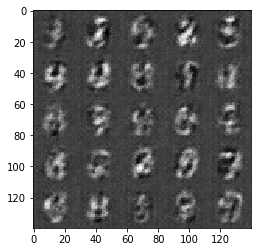

Epoch 1/2... batch: 245 Discriminator Loss: 0.8206... Generator Loss: 1.7111
Epoch 1/2... batch: 250 Discriminator Loss: 0.6383... Generator Loss: 1.5087
Epoch 1/2... batch: 255 Discriminator Loss: 0.6777... Generator Loss: 1.1688
Epoch 1/2... batch: 260 Discriminator Loss: 0.6473... Generator Loss: 1.1390


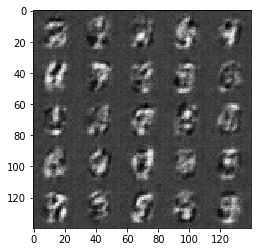

Epoch 1/2... batch: 265 Discriminator Loss: 0.7150... Generator Loss: 1.2967
Epoch 1/2... batch: 270 Discriminator Loss: 0.6247... Generator Loss: 1.1778
Epoch 1/2... batch: 275 Discriminator Loss: 0.7330... Generator Loss: 1.6077
Epoch 1/2... batch: 280 Discriminator Loss: 0.8049... Generator Loss: 0.8232


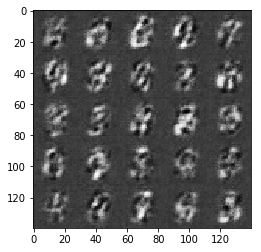

Epoch 1/2... batch: 285 Discriminator Loss: 0.6615... Generator Loss: 1.3378
Epoch 1/2... batch: 290 Discriminator Loss: 0.8049... Generator Loss: 1.8871
Epoch 1/2... batch: 295 Discriminator Loss: 0.6156... Generator Loss: 1.6246
Epoch 1/2... batch: 300 Discriminator Loss: 0.5943... Generator Loss: 1.8730


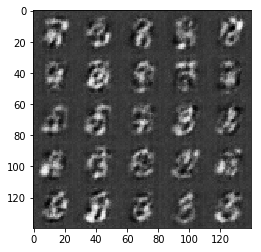

Epoch 1/2... batch: 305 Discriminator Loss: 0.5132... Generator Loss: 1.4436
Epoch 1/2... batch: 310 Discriminator Loss: 0.6230... Generator Loss: 1.1120
Epoch 1/2... batch: 315 Discriminator Loss: 0.5820... Generator Loss: 1.3812
Epoch 1/2... batch: 320 Discriminator Loss: 0.5156... Generator Loss: 1.7201


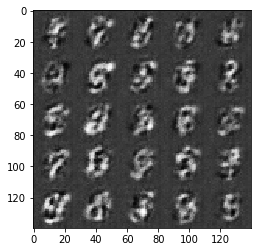

Epoch 1/2... batch: 325 Discriminator Loss: 1.0153... Generator Loss: 0.5437
Epoch 1/2... batch: 330 Discriminator Loss: 0.6185... Generator Loss: 1.2977
Epoch 1/2... batch: 335 Discriminator Loss: 0.5469... Generator Loss: 1.3450
Epoch 1/2... batch: 340 Discriminator Loss: 0.5532... Generator Loss: 1.2525


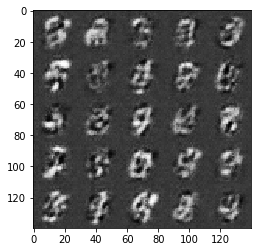

Epoch 1/2... batch: 345 Discriminator Loss: 0.6626... Generator Loss: 1.6785
Epoch 1/2... batch: 350 Discriminator Loss: 0.4523... Generator Loss: 1.6068
Epoch 1/2... batch: 355 Discriminator Loss: 0.5248... Generator Loss: 1.3207
Epoch 1/2... batch: 360 Discriminator Loss: 0.8562... Generator Loss: 0.7731


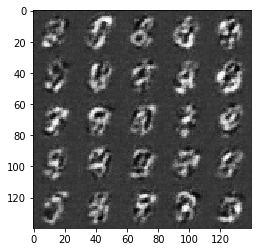

Epoch 1/2... batch: 365 Discriminator Loss: 0.7059... Generator Loss: 0.9139
Epoch 1/2... batch: 370 Discriminator Loss: 0.6114... Generator Loss: 1.1428
Epoch 1/2... batch: 375 Discriminator Loss: 0.5247... Generator Loss: 1.5648
Epoch 1/2... batch: 380 Discriminator Loss: 0.5547... Generator Loss: 1.2833


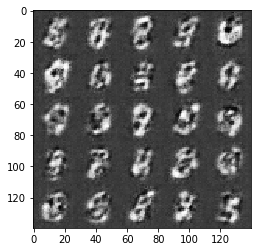

Epoch 1/2... batch: 385 Discriminator Loss: 0.4872... Generator Loss: 1.5405
Epoch 1/2... batch: 390 Discriminator Loss: 0.5236... Generator Loss: 2.3042
Epoch 1/2... batch: 395 Discriminator Loss: 0.5390... Generator Loss: 2.1327
Epoch 1/2... batch: 400 Discriminator Loss: 0.7605... Generator Loss: 0.8113


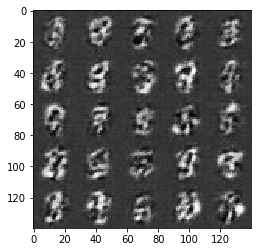

Epoch 1/2... batch: 405 Discriminator Loss: 0.5075... Generator Loss: 1.5020
Epoch 1/2... batch: 410 Discriminator Loss: 0.6569... Generator Loss: 0.9598
Epoch 1/2... batch: 415 Discriminator Loss: 0.5108... Generator Loss: 1.6157
Epoch 1/2... batch: 420 Discriminator Loss: 0.5428... Generator Loss: 1.3245


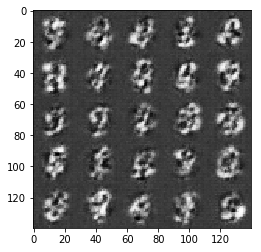

Epoch 1/2... batch: 425 Discriminator Loss: 0.5414... Generator Loss: 1.3201
Epoch 1/2... batch: 430 Discriminator Loss: 0.5414... Generator Loss: 2.0428
Epoch 1/2... batch: 435 Discriminator Loss: 0.4648... Generator Loss: 1.6347
Epoch 1/2... batch: 440 Discriminator Loss: 0.4753... Generator Loss: 1.7295


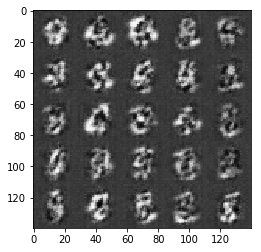

Epoch 1/2... batch: 445 Discriminator Loss: 0.4047... Generator Loss: 2.1520
Epoch 1/2... batch: 450 Discriminator Loss: 0.3877... Generator Loss: 1.7178
Epoch 1/2... batch: 455 Discriminator Loss: 0.4937... Generator Loss: 1.2303
Epoch 1/2... batch: 460 Discriminator Loss: 0.7533... Generator Loss: 0.8070


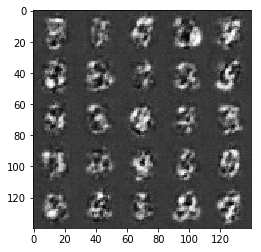

Epoch 1/2... batch: 465 Discriminator Loss: 0.5053... Generator Loss: 1.6647
Epoch 2/2... batch: 2 Discriminator Loss: 0.4328... Generator Loss: 1.7844
Epoch 2/2... batch: 7 Discriminator Loss: 0.4040... Generator Loss: 1.7874
Epoch 2/2... batch: 12 Discriminator Loss: 0.3718... Generator Loss: 1.9947


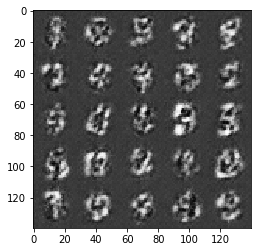

Epoch 2/2... batch: 17 Discriminator Loss: 0.4178... Generator Loss: 2.1578
Epoch 2/2... batch: 22 Discriminator Loss: 0.3920... Generator Loss: 2.0889
Epoch 2/2... batch: 27 Discriminator Loss: 0.3723... Generator Loss: 1.7587
Epoch 2/2... batch: 32 Discriminator Loss: 0.3814... Generator Loss: 2.0178


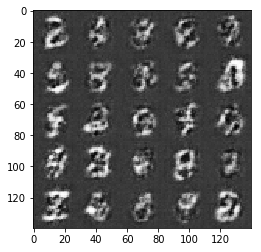

Epoch 2/2... batch: 37 Discriminator Loss: 0.3763... Generator Loss: 1.8143
Epoch 2/2... batch: 42 Discriminator Loss: 0.4364... Generator Loss: 1.5133
Epoch 2/2... batch: 47 Discriminator Loss: 0.4274... Generator Loss: 1.4288
Epoch 2/2... batch: 52 Discriminator Loss: 0.4335... Generator Loss: 2.4973


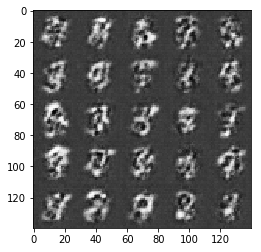

Epoch 2/2... batch: 57 Discriminator Loss: 0.7527... Generator Loss: 0.8240
Epoch 2/2... batch: 62 Discriminator Loss: 0.4220... Generator Loss: 1.9433
Epoch 2/2... batch: 67 Discriminator Loss: 0.3918... Generator Loss: 1.7888
Epoch 2/2... batch: 72 Discriminator Loss: 0.3847... Generator Loss: 1.9523


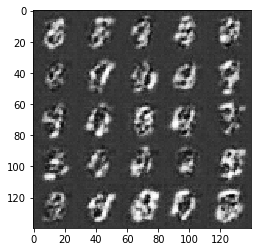

Epoch 2/2... batch: 77 Discriminator Loss: 0.4304... Generator Loss: 1.3108
Epoch 2/2... batch: 82 Discriminator Loss: 0.3837... Generator Loss: 2.4619
Epoch 2/2... batch: 87 Discriminator Loss: 0.3549... Generator Loss: 1.9156
Epoch 2/2... batch: 92 Discriminator Loss: 0.3307... Generator Loss: 1.9273


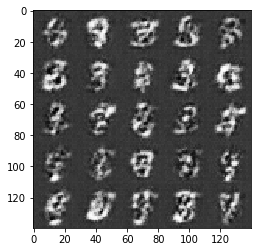

Epoch 2/2... batch: 97 Discriminator Loss: 0.3465... Generator Loss: 2.5321
Epoch 2/2... batch: 102 Discriminator Loss: 0.3708... Generator Loss: 1.9743
Epoch 2/2... batch: 107 Discriminator Loss: 0.6361... Generator Loss: 0.9004
Epoch 2/2... batch: 112 Discriminator Loss: 0.4159... Generator Loss: 1.3823


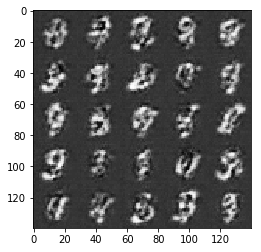

Epoch 2/2... batch: 117 Discriminator Loss: 0.3937... Generator Loss: 1.4544
Epoch 2/2... batch: 122 Discriminator Loss: 0.2712... Generator Loss: 2.0330
Epoch 2/2... batch: 127 Discriminator Loss: 0.2903... Generator Loss: 2.6185
Epoch 2/2... batch: 132 Discriminator Loss: 0.3186... Generator Loss: 2.2970


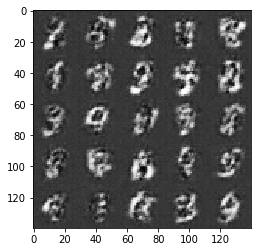

Epoch 2/2... batch: 137 Discriminator Loss: 0.5058... Generator Loss: 1.1737
Epoch 2/2... batch: 142 Discriminator Loss: 0.2209... Generator Loss: 2.3491
Epoch 2/2... batch: 147 Discriminator Loss: 0.2667... Generator Loss: 2.2430
Epoch 2/2... batch: 152 Discriminator Loss: 0.2747... Generator Loss: 2.5348


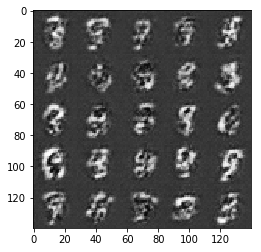

Epoch 2/2... batch: 157 Discriminator Loss: 0.2829... Generator Loss: 2.4289
Epoch 2/2... batch: 162 Discriminator Loss: 0.2872... Generator Loss: 2.1945
Epoch 2/2... batch: 167 Discriminator Loss: 0.3171... Generator Loss: 1.6907
Epoch 2/2... batch: 172 Discriminator Loss: 0.2817... Generator Loss: 2.7956


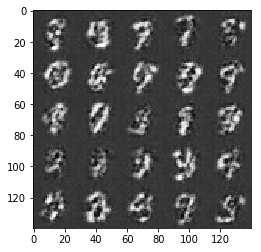

Epoch 2/2... batch: 177 Discriminator Loss: 0.3763... Generator Loss: 1.5096
Epoch 2/2... batch: 182 Discriminator Loss: 0.3447... Generator Loss: 2.7404
Epoch 2/2... batch: 187 Discriminator Loss: 0.2716... Generator Loss: 2.0723
Epoch 2/2... batch: 192 Discriminator Loss: 0.2527... Generator Loss: 2.1672


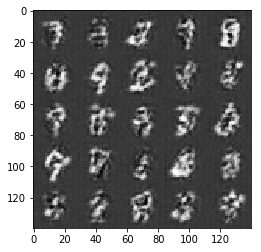

Epoch 2/2... batch: 197 Discriminator Loss: 0.2682... Generator Loss: 1.9769
Epoch 2/2... batch: 202 Discriminator Loss: 0.2713... Generator Loss: 1.9041
Epoch 2/2... batch: 207 Discriminator Loss: 0.2441... Generator Loss: 2.2199
Epoch 2/2... batch: 212 Discriminator Loss: 0.5000... Generator Loss: 1.1373


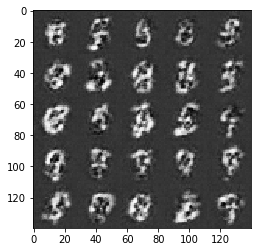

Epoch 2/2... batch: 217 Discriminator Loss: 0.2587... Generator Loss: 2.4637
Epoch 2/2... batch: 222 Discriminator Loss: 0.3007... Generator Loss: 2.0008
Epoch 2/2... batch: 227 Discriminator Loss: 0.3088... Generator Loss: 1.7500
Epoch 2/2... batch: 232 Discriminator Loss: 0.3223... Generator Loss: 1.5693


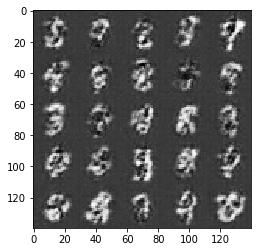

Epoch 2/2... batch: 237 Discriminator Loss: 0.2411... Generator Loss: 2.1243
Epoch 2/2... batch: 242 Discriminator Loss: 0.2727... Generator Loss: 3.1208
Epoch 2/2... batch: 247 Discriminator Loss: 0.2367... Generator Loss: 2.5405
Epoch 2/2... batch: 252 Discriminator Loss: 0.2435... Generator Loss: 2.3251


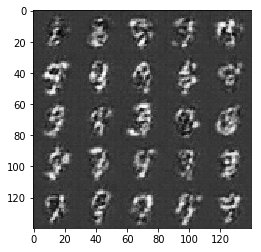

Epoch 2/2... batch: 257 Discriminator Loss: 0.3173... Generator Loss: 3.4101
Epoch 2/2... batch: 262 Discriminator Loss: 0.1950... Generator Loss: 2.5000
Epoch 2/2... batch: 267 Discriminator Loss: 0.2122... Generator Loss: 3.0533
Epoch 2/2... batch: 272 Discriminator Loss: 0.2789... Generator Loss: 2.0082


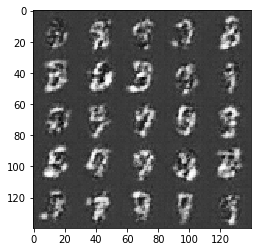

Epoch 2/2... batch: 277 Discriminator Loss: 0.2052... Generator Loss: 2.4486
Epoch 2/2... batch: 282 Discriminator Loss: 0.2521... Generator Loss: 2.5065
Epoch 2/2... batch: 287 Discriminator Loss: 0.2538... Generator Loss: 2.2476
Epoch 2/2... batch: 292 Discriminator Loss: 0.2311... Generator Loss: 2.9276


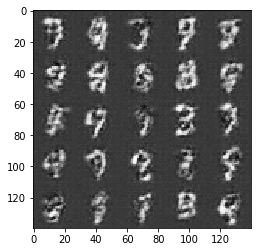

Epoch 2/2... batch: 297 Discriminator Loss: 0.2187... Generator Loss: 2.2555
Epoch 2/2... batch: 302 Discriminator Loss: 0.2202... Generator Loss: 2.1915
Epoch 2/2... batch: 307 Discriminator Loss: 0.2249... Generator Loss: 2.4282
Epoch 2/2... batch: 312 Discriminator Loss: 0.2416... Generator Loss: 2.9529


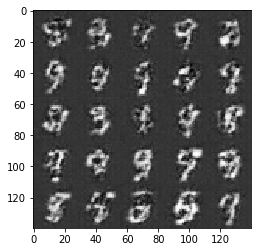

Epoch 2/2... batch: 317 Discriminator Loss: 0.1959... Generator Loss: 2.5642
Epoch 2/2... batch: 322 Discriminator Loss: 0.1927... Generator Loss: 2.9019
Epoch 2/2... batch: 327 Discriminator Loss: 0.5982... Generator Loss: 3.7024
Epoch 2/2... batch: 332 Discriminator Loss: 0.3515... Generator Loss: 1.6068


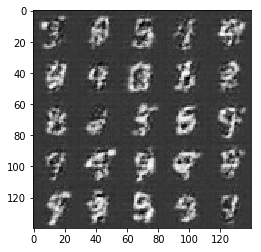

Epoch 2/2... batch: 337 Discriminator Loss: 0.2931... Generator Loss: 1.9184
Epoch 2/2... batch: 342 Discriminator Loss: 0.3703... Generator Loss: 1.4873
Epoch 2/2... batch: 347 Discriminator Loss: 0.1935... Generator Loss: 2.5019
Epoch 2/2... batch: 352 Discriminator Loss: 0.2513... Generator Loss: 2.4510


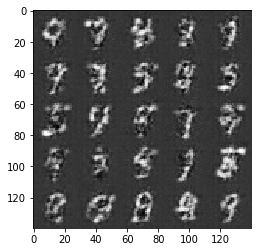

Epoch 2/2... batch: 357 Discriminator Loss: 0.2385... Generator Loss: 2.4049
Epoch 2/2... batch: 362 Discriminator Loss: 0.4521... Generator Loss: 1.2264
Epoch 2/2... batch: 367 Discriminator Loss: 0.2021... Generator Loss: 2.7120
Epoch 2/2... batch: 372 Discriminator Loss: 0.2286... Generator Loss: 2.2401


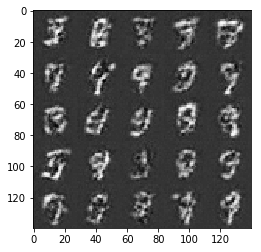

Epoch 2/2... batch: 377 Discriminator Loss: 0.2035... Generator Loss: 2.8750
Epoch 2/2... batch: 382 Discriminator Loss: 0.2281... Generator Loss: 2.3363
Epoch 2/2... batch: 387 Discriminator Loss: 0.1930... Generator Loss: 2.9173
Epoch 2/2... batch: 392 Discriminator Loss: 0.2027... Generator Loss: 2.5401


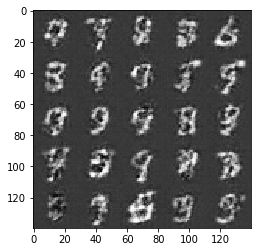

Epoch 2/2... batch: 397 Discriminator Loss: 0.4187... Generator Loss: 1.3330
Epoch 2/2... batch: 402 Discriminator Loss: 0.1758... Generator Loss: 2.7648
Epoch 2/2... batch: 407 Discriminator Loss: 0.2424... Generator Loss: 2.0736
Epoch 2/2... batch: 412 Discriminator Loss: 0.1939... Generator Loss: 2.6119


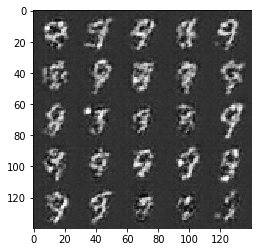

Epoch 2/2... batch: 417 Discriminator Loss: 0.1773... Generator Loss: 2.6936
Epoch 2/2... batch: 422 Discriminator Loss: 0.1848... Generator Loss: 2.5838
Epoch 2/2... batch: 427 Discriminator Loss: 0.1690... Generator Loss: 2.4803
Epoch 2/2... batch: 432 Discriminator Loss: 0.1987... Generator Loss: 2.6931


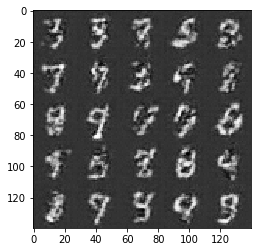

Epoch 2/2... batch: 437 Discriminator Loss: 0.2346... Generator Loss: 2.8953
Epoch 2/2... batch: 442 Discriminator Loss: 0.1571... Generator Loss: 3.0134
Epoch 2/2... batch: 447 Discriminator Loss: 0.4873... Generator Loss: 4.1635
Epoch 2/2... batch: 452 Discriminator Loss: 0.2644... Generator Loss: 2.6506


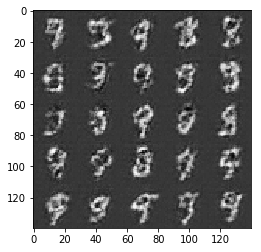

Epoch 2/2... batch: 457 Discriminator Loss: 0.1768... Generator Loss: 2.4238
Epoch 2/2... batch: 462 Discriminator Loss: 0.2026... Generator Loss: 2.3878
Epoch 2/2... batch: 467 Discriminator Loss: 0.1493... Generator Loss: 2.8263


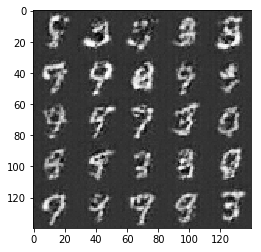

In [44]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
print(mnist_dataset.shape, mnist_dataset.image_mode)
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

batch size: 128
Epoch 1/1... batch: 5 Discriminator Loss: 1.0466... Generator Loss: 0.8915
Epoch 1/1... batch: 10 Discriminator Loss: 1.1786... Generator Loss: 0.6708
Epoch 1/1... batch: 15 Discriminator Loss: 0.2288... Generator Loss: 3.1417
Epoch 1/1... batch: 20 Discriminator Loss: 0.2884... Generator Loss: 2.3797


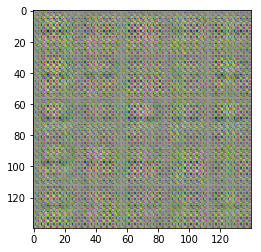

Epoch 1/1... batch: 25 Discriminator Loss: 1.3861... Generator Loss: 11.0570
Epoch 1/1... batch: 30 Discriminator Loss: 0.1766... Generator Loss: 11.4136
Epoch 1/1... batch: 35 Discriminator Loss: 1.7014... Generator Loss: 0.4731
Epoch 1/1... batch: 40 Discriminator Loss: 0.4527... Generator Loss: 3.6821


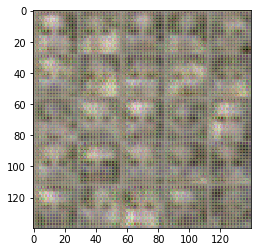

Epoch 1/1... batch: 45 Discriminator Loss: 0.4304... Generator Loss: 2.4159
Epoch 1/1... batch: 50 Discriminator Loss: 0.5254... Generator Loss: 1.4351
Epoch 1/1... batch: 55 Discriminator Loss: 0.5304... Generator Loss: 2.2496
Epoch 1/1... batch: 60 Discriminator Loss: 0.2373... Generator Loss: 2.4401


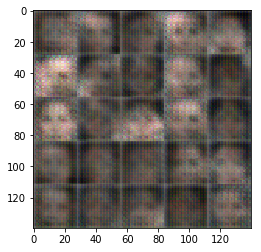

Epoch 1/1... batch: 65 Discriminator Loss: 0.1228... Generator Loss: 3.9560
Epoch 1/1... batch: 70 Discriminator Loss: 0.0385... Generator Loss: 5.3399
Epoch 1/1... batch: 75 Discriminator Loss: 0.1169... Generator Loss: 2.5631
Epoch 1/1... batch: 80 Discriminator Loss: 0.0118... Generator Loss: 8.6546


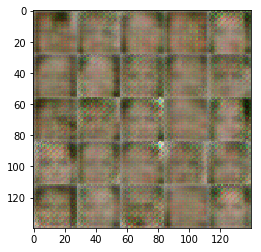

Epoch 1/1... batch: 85 Discriminator Loss: 0.1167... Generator Loss: 2.9579
Epoch 1/1... batch: 90 Discriminator Loss: 0.3503... Generator Loss: 1.6150
Epoch 1/1... batch: 95 Discriminator Loss: 0.2704... Generator Loss: 2.1004
Epoch 1/1... batch: 100 Discriminator Loss: 0.1789... Generator Loss: 2.6444


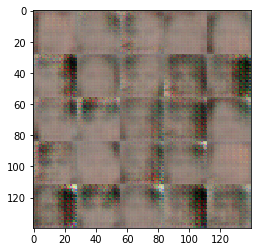

Epoch 1/1... batch: 105 Discriminator Loss: 0.2412... Generator Loss: 1.7679
Epoch 1/1... batch: 110 Discriminator Loss: 3.3254... Generator Loss: 0.0786
Epoch 1/1... batch: 115 Discriminator Loss: 0.1757... Generator Loss: 2.9381
Epoch 1/1... batch: 120 Discriminator Loss: 0.0941... Generator Loss: 4.2862


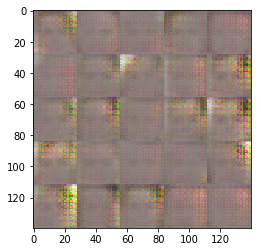

Epoch 1/1... batch: 125 Discriminator Loss: 0.3772... Generator Loss: 1.8122
Epoch 1/1... batch: 130 Discriminator Loss: 0.7871... Generator Loss: 4.0985
Epoch 1/1... batch: 135 Discriminator Loss: 0.2061... Generator Loss: 6.8872
Epoch 1/1... batch: 140 Discriminator Loss: 1.4480... Generator Loss: 6.4767


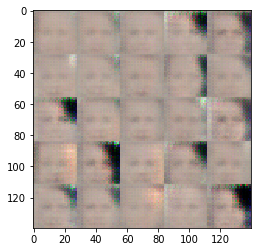

Epoch 1/1... batch: 145 Discriminator Loss: 0.4503... Generator Loss: 2.8656
Epoch 1/1... batch: 150 Discriminator Loss: 0.4875... Generator Loss: 1.6727
Epoch 1/1... batch: 155 Discriminator Loss: 0.6955... Generator Loss: 1.0753
Epoch 1/1... batch: 160 Discriminator Loss: 0.8289... Generator Loss: 1.1102


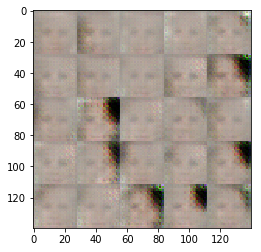

Epoch 1/1... batch: 165 Discriminator Loss: 0.4098... Generator Loss: 2.1471
Epoch 1/1... batch: 170 Discriminator Loss: 0.1475... Generator Loss: 3.1618
Epoch 1/1... batch: 175 Discriminator Loss: 0.3326... Generator Loss: 1.8264
Epoch 1/1... batch: 180 Discriminator Loss: 4.4489... Generator Loss: 5.2310


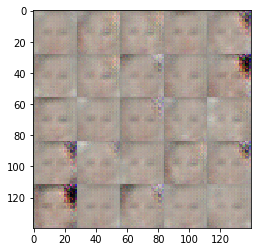

Epoch 1/1... batch: 185 Discriminator Loss: 0.2971... Generator Loss: 3.8802
Epoch 1/1... batch: 190 Discriminator Loss: 0.6598... Generator Loss: 1.5636
Epoch 1/1... batch: 195 Discriminator Loss: 0.2080... Generator Loss: 4.2301
Epoch 1/1... batch: 200 Discriminator Loss: 0.1567... Generator Loss: 4.1493


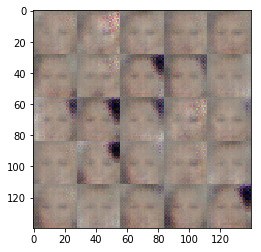

Epoch 1/1... batch: 205 Discriminator Loss: 1.1588... Generator Loss: 0.8137
Epoch 1/1... batch: 210 Discriminator Loss: 0.3559... Generator Loss: 2.4411
Epoch 1/1... batch: 215 Discriminator Loss: 0.3117... Generator Loss: 10.4491
Epoch 1/1... batch: 220 Discriminator Loss: 0.1558... Generator Loss: 3.1872


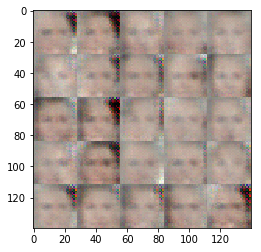

Epoch 1/1... batch: 225 Discriminator Loss: 0.6453... Generator Loss: 2.7300
Epoch 1/1... batch: 230 Discriminator Loss: 0.2247... Generator Loss: 3.4531
Epoch 1/1... batch: 235 Discriminator Loss: 0.4068... Generator Loss: 1.8003
Epoch 1/1... batch: 240 Discriminator Loss: 0.1192... Generator Loss: 3.4982


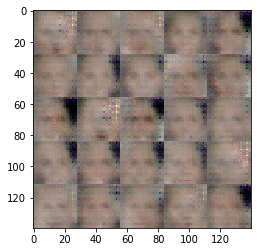

Epoch 1/1... batch: 245 Discriminator Loss: 1.2174... Generator Loss: 0.6655
Epoch 1/1... batch: 250 Discriminator Loss: 1.9849... Generator Loss: 3.6718
Epoch 1/1... batch: 255 Discriminator Loss: 0.3103... Generator Loss: 2.8322
Epoch 1/1... batch: 260 Discriminator Loss: 0.5935... Generator Loss: 1.2432


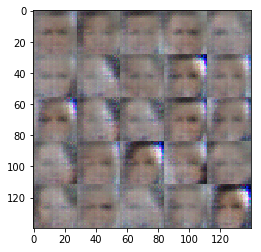

Epoch 1/1... batch: 265 Discriminator Loss: 0.2117... Generator Loss: 2.5703
Epoch 1/1... batch: 270 Discriminator Loss: 0.2259... Generator Loss: 3.3445
Epoch 1/1... batch: 275 Discriminator Loss: 0.1762... Generator Loss: 4.1217
Epoch 1/1... batch: 280 Discriminator Loss: 0.4390... Generator Loss: 2.2167


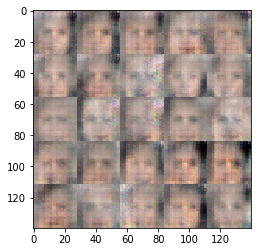

Epoch 1/1... batch: 285 Discriminator Loss: 2.2146... Generator Loss: 2.5781
Epoch 1/1... batch: 290 Discriminator Loss: 0.5505... Generator Loss: 3.1211
Epoch 1/1... batch: 295 Discriminator Loss: 0.6023... Generator Loss: 2.0556
Epoch 1/1... batch: 300 Discriminator Loss: 0.4593... Generator Loss: 2.4508


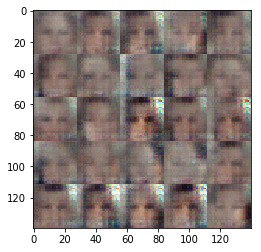

Epoch 1/1... batch: 305 Discriminator Loss: 0.4177... Generator Loss: 2.5411
Epoch 1/1... batch: 310 Discriminator Loss: 0.3622... Generator Loss: 2.7310
Epoch 1/1... batch: 315 Discriminator Loss: 0.3234... Generator Loss: 3.1649
Epoch 1/1... batch: 320 Discriminator Loss: 0.7155... Generator Loss: 2.6019


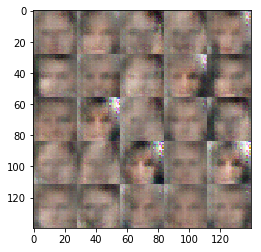

Epoch 1/1... batch: 325 Discriminator Loss: 0.6878... Generator Loss: 4.1965
Epoch 1/1... batch: 330 Discriminator Loss: 0.1520... Generator Loss: 5.0969
Epoch 1/1... batch: 335 Discriminator Loss: 0.4243... Generator Loss: 3.5677
Epoch 1/1... batch: 340 Discriminator Loss: 0.1495... Generator Loss: 6.6919


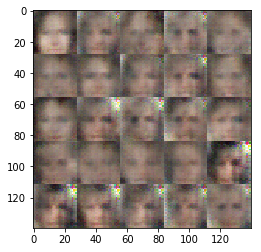

Epoch 1/1... batch: 345 Discriminator Loss: 0.2609... Generator Loss: 2.9196
Epoch 1/1... batch: 350 Discriminator Loss: 0.3635... Generator Loss: 2.7672
Epoch 1/1... batch: 355 Discriminator Loss: 0.1189... Generator Loss: 6.1977
Epoch 1/1... batch: 360 Discriminator Loss: 0.3714... Generator Loss: 2.2778


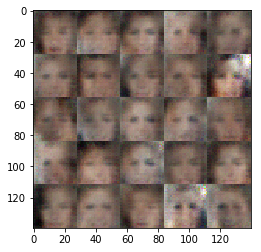

Epoch 1/1... batch: 365 Discriminator Loss: 0.3024... Generator Loss: 3.8365
Epoch 1/1... batch: 370 Discriminator Loss: 0.2937... Generator Loss: 2.5045
Epoch 1/1... batch: 375 Discriminator Loss: 3.8888... Generator Loss: 2.3730
Epoch 1/1... batch: 380 Discriminator Loss: 2.1212... Generator Loss: 3.8670


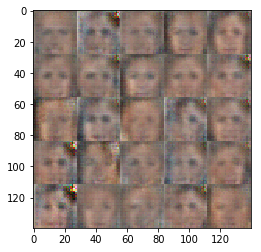

Epoch 1/1... batch: 385 Discriminator Loss: 0.7505... Generator Loss: 1.7621
Epoch 1/1... batch: 390 Discriminator Loss: 1.4522... Generator Loss: 0.3789
Epoch 1/1... batch: 395 Discriminator Loss: 0.6628... Generator Loss: 1.2279
Epoch 1/1... batch: 400 Discriminator Loss: 1.3782... Generator Loss: 1.7110


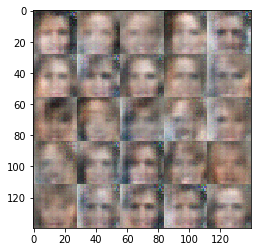

Epoch 1/1... batch: 405 Discriminator Loss: 0.8790... Generator Loss: 0.8494
Epoch 1/1... batch: 410 Discriminator Loss: 0.9009... Generator Loss: 2.9990
Epoch 1/1... batch: 415 Discriminator Loss: 0.7474... Generator Loss: 0.9353
Epoch 1/1... batch: 420 Discriminator Loss: 0.3769... Generator Loss: 3.2685


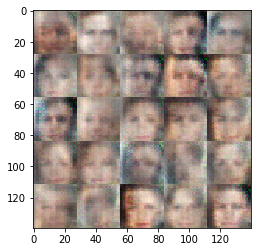

Epoch 1/1... batch: 425 Discriminator Loss: 0.3596... Generator Loss: 2.5362
Epoch 1/1... batch: 430 Discriminator Loss: 1.5721... Generator Loss: 0.4792
Epoch 1/1... batch: 435 Discriminator Loss: 0.6223... Generator Loss: 1.8666
Epoch 1/1... batch: 440 Discriminator Loss: 0.7976... Generator Loss: 2.2665


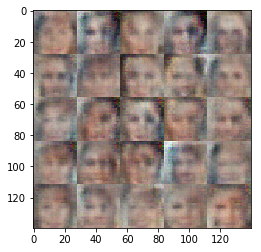

Epoch 1/1... batch: 445 Discriminator Loss: 0.5118... Generator Loss: 6.3027
Epoch 1/1... batch: 450 Discriminator Loss: 0.3653... Generator Loss: 2.4364
Epoch 1/1... batch: 455 Discriminator Loss: 1.9111... Generator Loss: 0.4198
Epoch 1/1... batch: 460 Discriminator Loss: 1.3220... Generator Loss: 0.4458


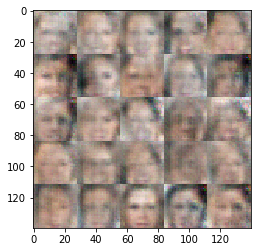

Epoch 1/1... batch: 465 Discriminator Loss: 0.5374... Generator Loss: 1.6398
Epoch 1/1... batch: 470 Discriminator Loss: 0.6363... Generator Loss: 1.9377
Epoch 1/1... batch: 475 Discriminator Loss: 0.7149... Generator Loss: 5.2683
Epoch 1/1... batch: 480 Discriminator Loss: 3.3283... Generator Loss: 0.0654


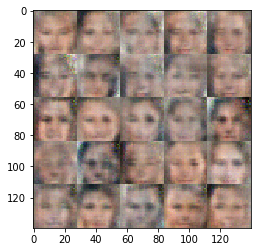

Epoch 1/1... batch: 485 Discriminator Loss: 0.2642... Generator Loss: 3.4774
Epoch 1/1... batch: 490 Discriminator Loss: 0.4251... Generator Loss: 2.8062
Epoch 1/1... batch: 495 Discriminator Loss: 0.1944... Generator Loss: 4.5400
Epoch 1/1... batch: 500 Discriminator Loss: 1.2915... Generator Loss: 0.6139


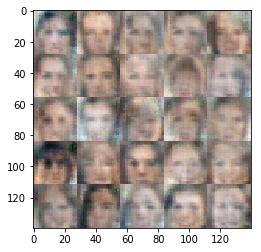

Epoch 1/1... batch: 505 Discriminator Loss: 0.7327... Generator Loss: 1.1403
Epoch 1/1... batch: 510 Discriminator Loss: 0.5061... Generator Loss: 1.9246
Epoch 1/1... batch: 515 Discriminator Loss: 0.2861... Generator Loss: 3.0620
Epoch 1/1... batch: 520 Discriminator Loss: 0.4178... Generator Loss: 2.0566


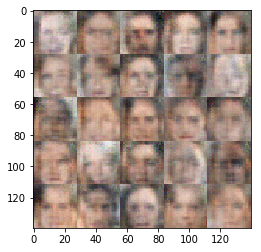

Epoch 1/1... batch: 525 Discriminator Loss: 1.5489... Generator Loss: 1.0844
Epoch 1/1... batch: 530 Discriminator Loss: 2.4620... Generator Loss: 0.3862
Epoch 1/1... batch: 535 Discriminator Loss: 0.6700... Generator Loss: 1.1016
Epoch 1/1... batch: 540 Discriminator Loss: 1.0118... Generator Loss: 0.7747


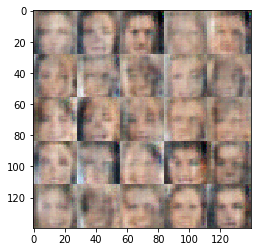

Epoch 1/1... batch: 545 Discriminator Loss: 0.3840... Generator Loss: 2.7127
Epoch 1/1... batch: 550 Discriminator Loss: 0.7784... Generator Loss: 0.9036
Epoch 1/1... batch: 555 Discriminator Loss: 0.4565... Generator Loss: 5.6956
Epoch 1/1... batch: 560 Discriminator Loss: 0.2933... Generator Loss: 5.0687


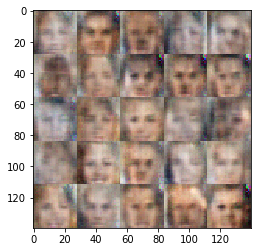

Epoch 1/1... batch: 565 Discriminator Loss: 0.2431... Generator Loss: 6.1507
Epoch 1/1... batch: 570 Discriminator Loss: 0.4736... Generator Loss: 3.0656
Epoch 1/1... batch: 575 Discriminator Loss: 0.4410... Generator Loss: 6.6520
Epoch 1/1... batch: 580 Discriminator Loss: 0.1652... Generator Loss: 4.0721


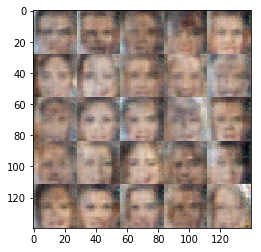

Epoch 1/1... batch: 585 Discriminator Loss: 0.9054... Generator Loss: 0.9959
Epoch 1/1... batch: 590 Discriminator Loss: 0.2088... Generator Loss: 4.5885
Epoch 1/1... batch: 595 Discriminator Loss: 1.1677... Generator Loss: 0.5697
Epoch 1/1... batch: 600 Discriminator Loss: 0.2723... Generator Loss: 4.0114


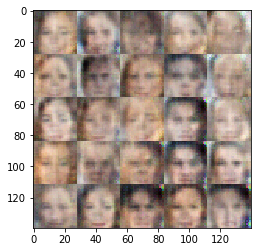

Epoch 1/1... batch: 605 Discriminator Loss: 0.1789... Generator Loss: 4.1274
Epoch 1/1... batch: 610 Discriminator Loss: 0.3002... Generator Loss: 3.4647
Epoch 1/1... batch: 615 Discriminator Loss: 0.6293... Generator Loss: 1.2048
Epoch 1/1... batch: 620 Discriminator Loss: 0.2672... Generator Loss: 3.4133


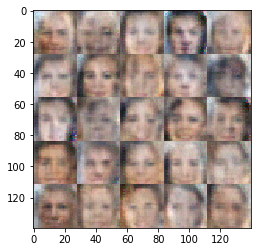

Epoch 1/1... batch: 625 Discriminator Loss: 0.3537... Generator Loss: 5.9233
Epoch 1/1... batch: 630 Discriminator Loss: 0.8062... Generator Loss: 1.0238
Epoch 1/1... batch: 635 Discriminator Loss: 1.9639... Generator Loss: 3.4386
Epoch 1/1... batch: 640 Discriminator Loss: 1.6712... Generator Loss: 0.4990


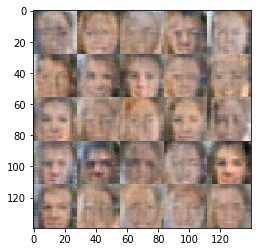

Epoch 1/1... batch: 645 Discriminator Loss: 0.5207... Generator Loss: 4.7966
Epoch 1/1... batch: 650 Discriminator Loss: 0.9065... Generator Loss: 0.9361
Epoch 1/1... batch: 655 Discriminator Loss: 0.1419... Generator Loss: 7.9504
Epoch 1/1... batch: 660 Discriminator Loss: 0.5264... Generator Loss: 1.7731


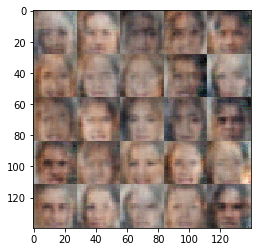

Epoch 1/1... batch: 665 Discriminator Loss: 0.4561... Generator Loss: 2.2863
Epoch 1/1... batch: 670 Discriminator Loss: 0.3981... Generator Loss: 2.3727
Epoch 1/1... batch: 675 Discriminator Loss: 0.2129... Generator Loss: 4.6692
Epoch 1/1... batch: 680 Discriminator Loss: 0.6503... Generator Loss: 1.3903


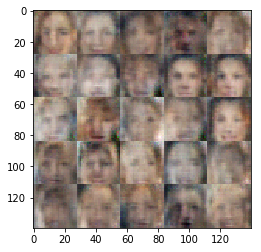

Epoch 1/1... batch: 685 Discriminator Loss: 0.3947... Generator Loss: 4.3830
Epoch 1/1... batch: 690 Discriminator Loss: 0.1690... Generator Loss: 5.3350
Epoch 1/1... batch: 695 Discriminator Loss: 0.3659... Generator Loss: 2.2267
Epoch 1/1... batch: 700 Discriminator Loss: 1.2386... Generator Loss: 4.2838


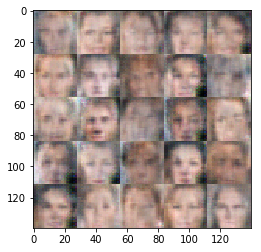

Epoch 1/1... batch: 705 Discriminator Loss: 0.7303... Generator Loss: 3.6032
Epoch 1/1... batch: 710 Discriminator Loss: 1.4933... Generator Loss: 0.4387
Epoch 1/1... batch: 715 Discriminator Loss: 0.5254... Generator Loss: 2.2089
Epoch 1/1... batch: 720 Discriminator Loss: 1.5756... Generator Loss: 0.6382


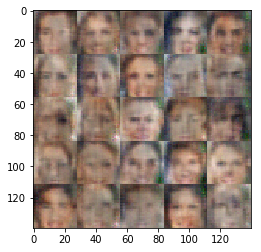

Epoch 1/1... batch: 725 Discriminator Loss: 0.4366... Generator Loss: 5.4649
Epoch 1/1... batch: 730 Discriminator Loss: 0.3291... Generator Loss: 3.3540
Epoch 1/1... batch: 735 Discriminator Loss: 0.2901... Generator Loss: 5.5218
Epoch 1/1... batch: 740 Discriminator Loss: 0.1945... Generator Loss: 4.1965


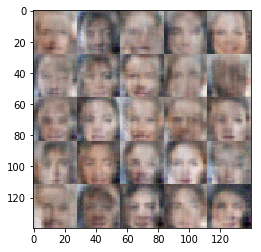

Epoch 1/1... batch: 745 Discriminator Loss: 0.6218... Generator Loss: 1.1736
Epoch 1/1... batch: 750 Discriminator Loss: 0.1286... Generator Loss: 5.3378
Epoch 1/1... batch: 755 Discriminator Loss: 1.0342... Generator Loss: 0.6797
Epoch 1/1... batch: 760 Discriminator Loss: 1.1231... Generator Loss: 3.3624


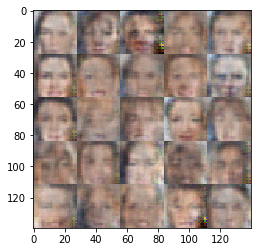

Epoch 1/1... batch: 765 Discriminator Loss: 2.9487... Generator Loss: 2.2555
Epoch 1/1... batch: 770 Discriminator Loss: 2.0912... Generator Loss: 3.2423
Epoch 1/1... batch: 775 Discriminator Loss: 0.5859... Generator Loss: 4.0295
Epoch 1/1... batch: 780 Discriminator Loss: 0.6054... Generator Loss: 1.8556


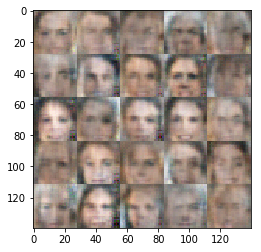

Epoch 1/1... batch: 785 Discriminator Loss: 0.3267... Generator Loss: 5.2894
Epoch 1/1... batch: 790 Discriminator Loss: 0.4872... Generator Loss: 2.3082
Epoch 1/1... batch: 795 Discriminator Loss: 0.6442... Generator Loss: 2.4651
Epoch 1/1... batch: 800 Discriminator Loss: 0.2730... Generator Loss: 7.3780


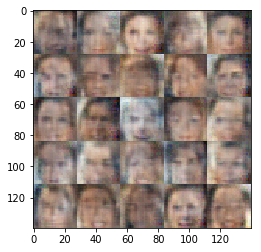

Epoch 1/1... batch: 805 Discriminator Loss: 0.8648... Generator Loss: 8.1213
Epoch 1/1... batch: 810 Discriminator Loss: 0.9151... Generator Loss: 0.7271
Epoch 1/1... batch: 815 Discriminator Loss: 1.1877... Generator Loss: 0.6416
Epoch 1/1... batch: 820 Discriminator Loss: 0.3162... Generator Loss: 2.4576


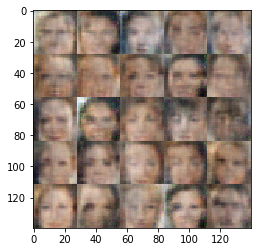

Epoch 1/1... batch: 825 Discriminator Loss: 1.2151... Generator Loss: 6.3162
Epoch 1/1... batch: 830 Discriminator Loss: 0.2640... Generator Loss: 5.4169
Epoch 1/1... batch: 835 Discriminator Loss: 0.2899... Generator Loss: 2.9523
Epoch 1/1... batch: 840 Discriminator Loss: 0.2517... Generator Loss: 9.2772


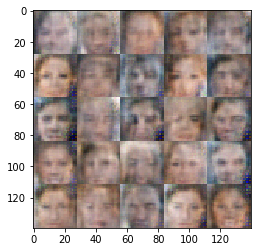

Epoch 1/1... batch: 845 Discriminator Loss: 0.4733... Generator Loss: 1.9218
Epoch 1/1... batch: 850 Discriminator Loss: 0.1214... Generator Loss: 7.8561
Epoch 1/1... batch: 855 Discriminator Loss: 1.1345... Generator Loss: 4.4424
Epoch 1/1... batch: 860 Discriminator Loss: 0.8155... Generator Loss: 1.6202


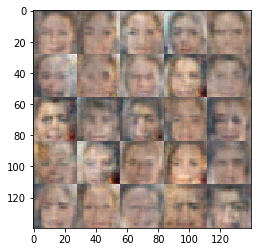

Epoch 1/1... batch: 865 Discriminator Loss: 0.5168... Generator Loss: 10.6545
Epoch 1/1... batch: 870 Discriminator Loss: 0.2390... Generator Loss: 3.0217
Epoch 1/1... batch: 875 Discriminator Loss: 0.8436... Generator Loss: 0.8545
Epoch 1/1... batch: 880 Discriminator Loss: 0.8822... Generator Loss: 1.2832


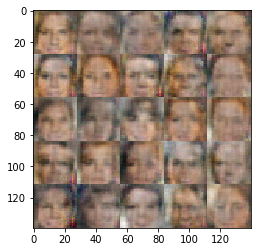

Epoch 1/1... batch: 885 Discriminator Loss: 1.7490... Generator Loss: 0.3330
Epoch 1/1... batch: 890 Discriminator Loss: 1.0165... Generator Loss: 0.9002
Epoch 1/1... batch: 895 Discriminator Loss: 0.9221... Generator Loss: 0.8394
Epoch 1/1... batch: 900 Discriminator Loss: 0.9174... Generator Loss: 0.7832


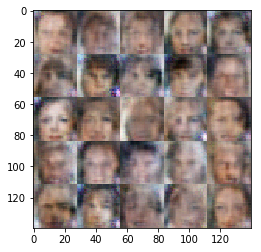

Epoch 1/1... batch: 905 Discriminator Loss: 1.2394... Generator Loss: 0.7550
Epoch 1/1... batch: 910 Discriminator Loss: 1.2548... Generator Loss: 0.4607
Epoch 1/1... batch: 915 Discriminator Loss: 1.2555... Generator Loss: 0.4888
Epoch 1/1... batch: 920 Discriminator Loss: 0.5339... Generator Loss: 2.0475


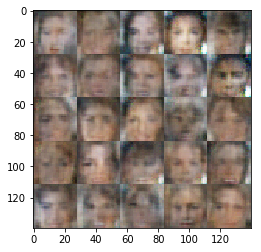

Epoch 1/1... batch: 925 Discriminator Loss: 0.8156... Generator Loss: 1.9066
Epoch 1/1... batch: 930 Discriminator Loss: 0.8711... Generator Loss: 1.4237
Epoch 1/1... batch: 935 Discriminator Loss: 1.1305... Generator Loss: 0.8316
Epoch 1/1... batch: 940 Discriminator Loss: 0.4434... Generator Loss: 5.1231


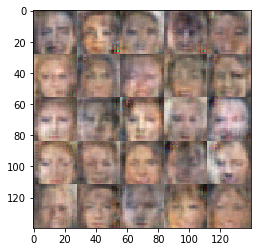

Epoch 1/1... batch: 945 Discriminator Loss: 0.3937... Generator Loss: 4.2003
Epoch 1/1... batch: 950 Discriminator Loss: 0.8995... Generator Loss: 2.0641
Epoch 1/1... batch: 955 Discriminator Loss: 0.5040... Generator Loss: 2.7065
Epoch 1/1... batch: 960 Discriminator Loss: 0.4433... Generator Loss: 2.2229


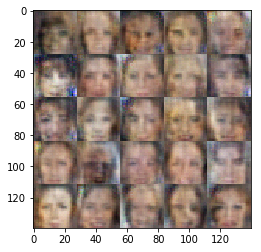

Epoch 1/1... batch: 965 Discriminator Loss: 1.5134... Generator Loss: 0.3911
Epoch 1/1... batch: 970 Discriminator Loss: 0.5189... Generator Loss: 1.9986
Epoch 1/1... batch: 975 Discriminator Loss: 0.4336... Generator Loss: 2.5316
Epoch 1/1... batch: 980 Discriminator Loss: 1.7874... Generator Loss: 0.3145


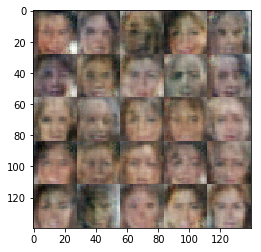

Epoch 1/1... batch: 985 Discriminator Loss: 1.9232... Generator Loss: 0.9905
Epoch 1/1... batch: 990 Discriminator Loss: 1.9737... Generator Loss: 0.3068
Epoch 1/1... batch: 995 Discriminator Loss: 0.9286... Generator Loss: 5.0533
Epoch 1/1... batch: 1000 Discriminator Loss: 0.6835... Generator Loss: 1.3801


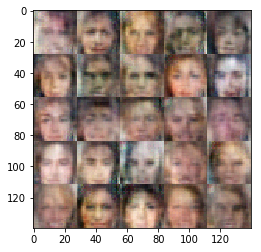

Epoch 1/1... batch: 1005 Discriminator Loss: 0.8009... Generator Loss: 5.6306
Epoch 1/1... batch: 1010 Discriminator Loss: 0.6315... Generator Loss: 1.4136
Epoch 1/1... batch: 1015 Discriminator Loss: 0.6193... Generator Loss: 1.3042
Epoch 1/1... batch: 1020 Discriminator Loss: 0.8359... Generator Loss: 5.6342


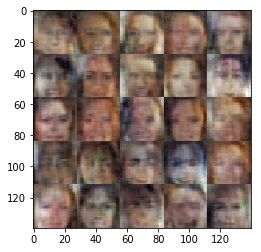

Epoch 1/1... batch: 1025 Discriminator Loss: 0.7745... Generator Loss: 2.0321
Epoch 1/1... batch: 1030 Discriminator Loss: 1.0766... Generator Loss: 4.9431
Epoch 1/1... batch: 1035 Discriminator Loss: 0.6858... Generator Loss: 1.1522
Epoch 1/1... batch: 1040 Discriminator Loss: 0.5005... Generator Loss: 2.8472


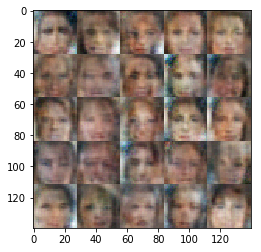

Epoch 1/1... batch: 1045 Discriminator Loss: 0.9958... Generator Loss: 0.7860
Epoch 1/1... batch: 1050 Discriminator Loss: 0.5067... Generator Loss: 2.5366
Epoch 1/1... batch: 1055 Discriminator Loss: 0.3052... Generator Loss: 3.6005
Epoch 1/1... batch: 1060 Discriminator Loss: 0.4712... Generator Loss: 1.8690


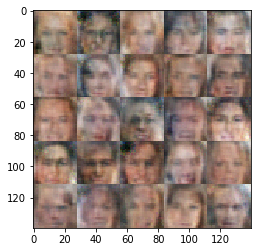

Epoch 1/1... batch: 1065 Discriminator Loss: 0.4572... Generator Loss: 4.6436
Epoch 1/1... batch: 1070 Discriminator Loss: 0.2144... Generator Loss: 3.1217
Epoch 1/1... batch: 1075 Discriminator Loss: 1.2957... Generator Loss: 2.4533
Epoch 1/1... batch: 1080 Discriminator Loss: 2.4920... Generator Loss: 3.8017


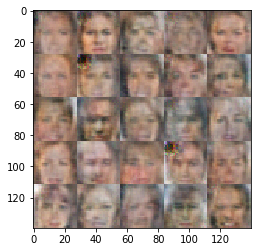

Epoch 1/1... batch: 1085 Discriminator Loss: 1.4078... Generator Loss: 4.0663
Epoch 1/1... batch: 1090 Discriminator Loss: 0.5483... Generator Loss: 4.3089
Epoch 1/1... batch: 1095 Discriminator Loss: 0.6664... Generator Loss: 1.3175
Epoch 1/1... batch: 1100 Discriminator Loss: 0.3186... Generator Loss: 3.0081


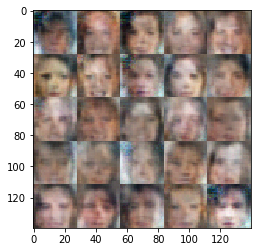

Epoch 1/1... batch: 1105 Discriminator Loss: 0.6509... Generator Loss: 1.4952
Epoch 1/1... batch: 1110 Discriminator Loss: 0.5277... Generator Loss: 3.4094
Epoch 1/1... batch: 1115 Discriminator Loss: 1.1813... Generator Loss: 3.7033
Epoch 1/1... batch: 1120 Discriminator Loss: 1.7927... Generator Loss: 1.8806


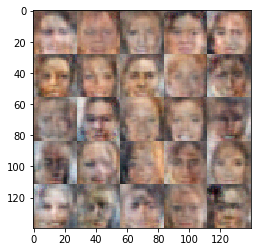

Epoch 1/1... batch: 1125 Discriminator Loss: 1.3886... Generator Loss: 1.5147
Epoch 1/1... batch: 1130 Discriminator Loss: 0.7355... Generator Loss: 1.1778
Epoch 1/1... batch: 1135 Discriminator Loss: 0.8388... Generator Loss: 0.8652
Epoch 1/1... batch: 1140 Discriminator Loss: 0.3573... Generator Loss: 4.0778


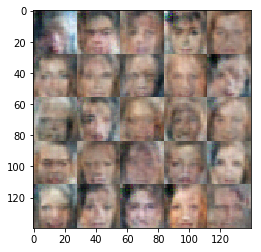

Epoch 1/1... batch: 1145 Discriminator Loss: 1.0334... Generator Loss: 0.6965
Epoch 1/1... batch: 1150 Discriminator Loss: 0.6083... Generator Loss: 1.3790
Epoch 1/1... batch: 1155 Discriminator Loss: 0.4858... Generator Loss: 2.5135
Epoch 1/1... batch: 1160 Discriminator Loss: 0.9178... Generator Loss: 0.8259


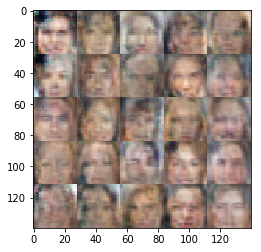

Epoch 1/1... batch: 1165 Discriminator Loss: 2.0488... Generator Loss: 5.1304
Epoch 1/1... batch: 1170 Discriminator Loss: 1.2242... Generator Loss: 4.7116
Epoch 1/1... batch: 1175 Discriminator Loss: 0.3282... Generator Loss: 3.7903
Epoch 1/1... batch: 1180 Discriminator Loss: 0.5278... Generator Loss: 2.1200


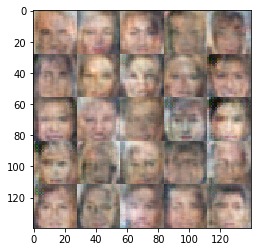

Epoch 1/1... batch: 1185 Discriminator Loss: 1.2100... Generator Loss: 7.8536
Epoch 1/1... batch: 1190 Discriminator Loss: 0.3306... Generator Loss: 3.3766
Epoch 1/1... batch: 1195 Discriminator Loss: 0.7494... Generator Loss: 1.0804
Epoch 1/1... batch: 1200 Discriminator Loss: 0.3960... Generator Loss: 4.2271


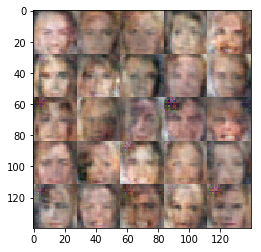

Epoch 1/1... batch: 1205 Discriminator Loss: 0.5157... Generator Loss: 1.6498
Epoch 1/1... batch: 1210 Discriminator Loss: 0.5518... Generator Loss: 9.1524
Epoch 1/1... batch: 1215 Discriminator Loss: 0.8406... Generator Loss: 1.7162
Epoch 1/1... batch: 1220 Discriminator Loss: 0.3077... Generator Loss: 4.1521


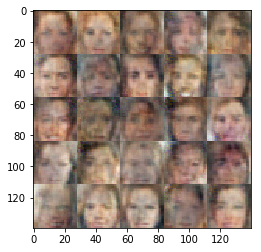

Epoch 1/1... batch: 1225 Discriminator Loss: 0.3624... Generator Loss: 2.4106
Epoch 1/1... batch: 1230 Discriminator Loss: 0.7503... Generator Loss: 3.2186
Epoch 1/1... batch: 1235 Discriminator Loss: 1.2313... Generator Loss: 0.4660
Epoch 1/1... batch: 1240 Discriminator Loss: 1.5113... Generator Loss: 1.1687


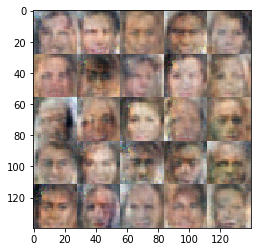

Epoch 1/1... batch: 1245 Discriminator Loss: 0.6226... Generator Loss: 3.9438
Epoch 1/1... batch: 1250 Discriminator Loss: 0.4030... Generator Loss: 4.6841
Epoch 1/1... batch: 1255 Discriminator Loss: 0.5018... Generator Loss: 4.1231
Epoch 1/1... batch: 1260 Discriminator Loss: 0.5484... Generator Loss: 1.6993


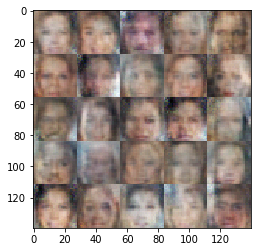

Epoch 1/1... batch: 1265 Discriminator Loss: 0.4242... Generator Loss: 1.9940
Epoch 1/1... batch: 1270 Discriminator Loss: 0.3113... Generator Loss: 3.4958
Epoch 1/1... batch: 1275 Discriminator Loss: 0.4388... Generator Loss: 4.8663
Epoch 1/1... batch: 1280 Discriminator Loss: 0.9390... Generator Loss: 0.8645


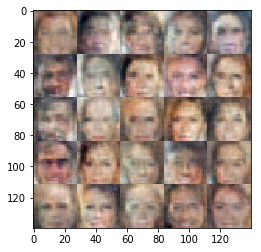

Epoch 1/1... batch: 1285 Discriminator Loss: 1.4334... Generator Loss: 1.0582
Epoch 1/1... batch: 1290 Discriminator Loss: 0.9023... Generator Loss: 2.2330
Epoch 1/1... batch: 1295 Discriminator Loss: 0.5365... Generator Loss: 3.7586
Epoch 1/1... batch: 1300 Discriminator Loss: 0.5602... Generator Loss: 1.6402


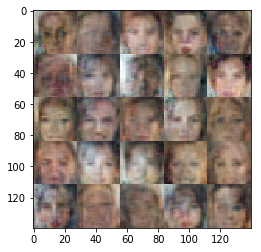

Epoch 1/1... batch: 1305 Discriminator Loss: 0.6229... Generator Loss: 6.3341
Epoch 1/1... batch: 1310 Discriminator Loss: 0.3723... Generator Loss: 5.0605
Epoch 1/1... batch: 1315 Discriminator Loss: 0.7021... Generator Loss: 0.9994
Epoch 1/1... batch: 1320 Discriminator Loss: 2.1746... Generator Loss: 4.7342


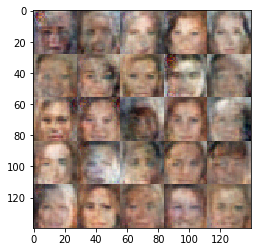

Epoch 1/1... batch: 1325 Discriminator Loss: 0.3695... Generator Loss: 6.1552
Epoch 1/1... batch: 1330 Discriminator Loss: 0.7702... Generator Loss: 1.1915
Epoch 1/1... batch: 1335 Discriminator Loss: 0.3136... Generator Loss: 4.4501
Epoch 1/1... batch: 1340 Discriminator Loss: 0.3204... Generator Loss: 3.0411


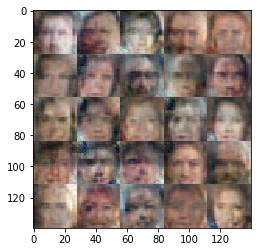

Epoch 1/1... batch: 1345 Discriminator Loss: 1.2122... Generator Loss: 0.6841
Epoch 1/1... batch: 1350 Discriminator Loss: 0.6006... Generator Loss: 2.8816
Epoch 1/1... batch: 1355 Discriminator Loss: 0.6968... Generator Loss: 1.0490
Epoch 1/1... batch: 1360 Discriminator Loss: 0.6067... Generator Loss: 1.2242


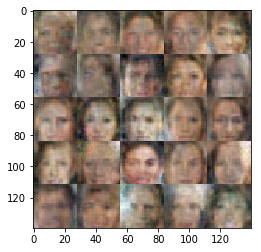

Epoch 1/1... batch: 1365 Discriminator Loss: 0.4174... Generator Loss: 2.3831
Epoch 1/1... batch: 1370 Discriminator Loss: 0.2426... Generator Loss: 5.0862
Epoch 1/1... batch: 1375 Discriminator Loss: 0.1960... Generator Loss: 2.9539
Epoch 1/1... batch: 1380 Discriminator Loss: 0.3845... Generator Loss: 2.5302


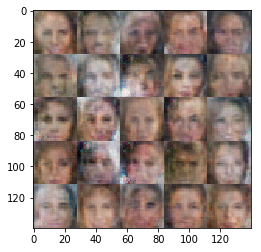

Epoch 1/1... batch: 1385 Discriminator Loss: 0.2810... Generator Loss: 3.7409
Epoch 1/1... batch: 1390 Discriminator Loss: 2.6919... Generator Loss: 0.2255
Epoch 1/1... batch: 1395 Discriminator Loss: 1.4756... Generator Loss: 1.4283
Epoch 1/1... batch: 1400 Discriminator Loss: 3.8342... Generator Loss: 1.7257


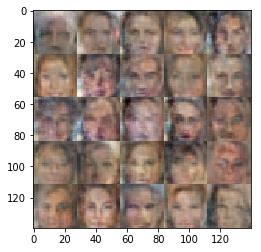

Epoch 1/1... batch: 1405 Discriminator Loss: 0.6950... Generator Loss: 1.3690
Epoch 1/1... batch: 1410 Discriminator Loss: 0.7782... Generator Loss: 1.6234
Epoch 1/1... batch: 1415 Discriminator Loss: 0.6661... Generator Loss: 1.3688
Epoch 1/1... batch: 1420 Discriminator Loss: 0.7992... Generator Loss: 4.2815


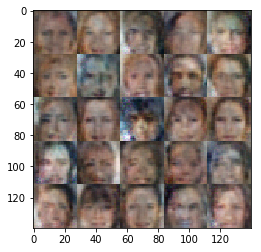

Epoch 1/1... batch: 1425 Discriminator Loss: 0.5243... Generator Loss: 1.8145
Epoch 1/1... batch: 1430 Discriminator Loss: 0.4877... Generator Loss: 2.1567
Epoch 1/1... batch: 1435 Discriminator Loss: 0.6072... Generator Loss: 2.0325
Epoch 1/1... batch: 1440 Discriminator Loss: 1.9280... Generator Loss: 0.7917


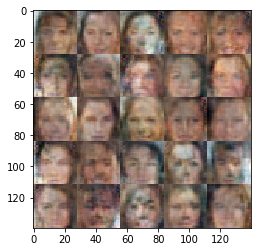

Epoch 1/1... batch: 1445 Discriminator Loss: 0.8829... Generator Loss: 0.9536
Epoch 1/1... batch: 1450 Discriminator Loss: 0.4018... Generator Loss: 3.4200
Epoch 1/1... batch: 1455 Discriminator Loss: 1.8619... Generator Loss: 0.2675
Epoch 1/1... batch: 1460 Discriminator Loss: 0.8364... Generator Loss: 2.8657


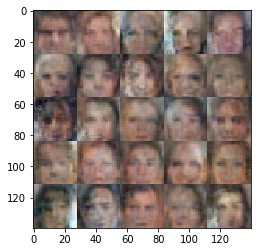

Epoch 1/1... batch: 1465 Discriminator Loss: 0.6205... Generator Loss: 1.3366
Epoch 1/1... batch: 1470 Discriminator Loss: 0.9771... Generator Loss: 0.9276
Epoch 1/1... batch: 1475 Discriminator Loss: 0.6710... Generator Loss: 4.3074
Epoch 1/1... batch: 1480 Discriminator Loss: 0.5290... Generator Loss: 1.6528


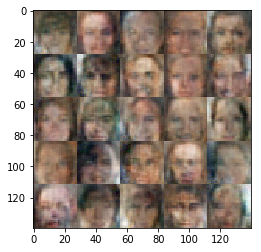

Epoch 1/1... batch: 1485 Discriminator Loss: 0.7945... Generator Loss: 1.5580
Epoch 1/1... batch: 1490 Discriminator Loss: 1.7762... Generator Loss: 3.0908
Epoch 1/1... batch: 1495 Discriminator Loss: 0.3859... Generator Loss: 2.5161
Epoch 1/1... batch: 1500 Discriminator Loss: 0.6803... Generator Loss: 1.0867


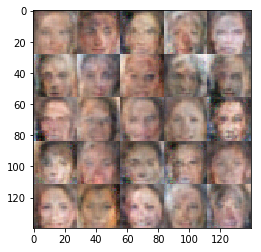

Epoch 1/1... batch: 1505 Discriminator Loss: 0.7311... Generator Loss: 1.0374
Epoch 1/1... batch: 1510 Discriminator Loss: 0.3906... Generator Loss: 2.1371
Epoch 1/1... batch: 1515 Discriminator Loss: 1.2960... Generator Loss: 0.5390
Epoch 1/1... batch: 1520 Discriminator Loss: 2.4790... Generator Loss: 3.8072


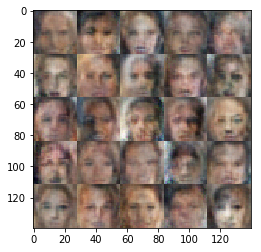

Epoch 1/1... batch: 1525 Discriminator Loss: 1.3480... Generator Loss: 0.4616
Epoch 1/1... batch: 1530 Discriminator Loss: 0.7588... Generator Loss: 1.2929
Epoch 1/1... batch: 1535 Discriminator Loss: 0.4977... Generator Loss: 2.0296
Epoch 1/1... batch: 1540 Discriminator Loss: 0.4401... Generator Loss: 4.6097


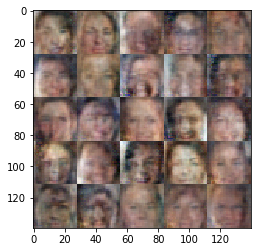

Epoch 1/1... batch: 1545 Discriminator Loss: 2.4103... Generator Loss: 0.2228
Epoch 1/1... batch: 1550 Discriminator Loss: 1.8144... Generator Loss: 0.9494
Epoch 1/1... batch: 1555 Discriminator Loss: 0.8420... Generator Loss: 1.7687
Epoch 1/1... batch: 1560 Discriminator Loss: 0.8496... Generator Loss: 0.9434


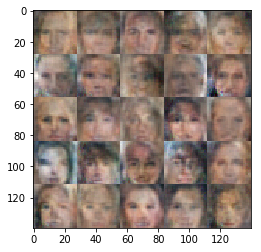

Epoch 1/1... batch: 1565 Discriminator Loss: 0.8283... Generator Loss: 4.2079
Epoch 1/1... batch: 1570 Discriminator Loss: 0.6791... Generator Loss: 1.2515
Epoch 1/1... batch: 1575 Discriminator Loss: 0.3925... Generator Loss: 4.5493
Epoch 1/1... batch: 1580 Discriminator Loss: 0.5974... Generator Loss: 1.3426


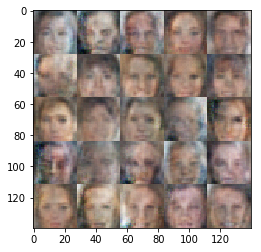

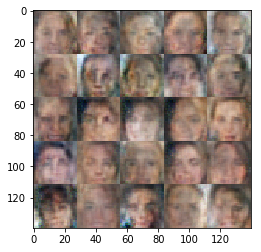

In [46]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.